Workshop Algoritmos Geneticos p2 - Variaciones
========================================

En esta parte del workshop vamos a ver algunas variaciones en la implementación de este tipo de algoritmos y sus implicaciones.

Para esto vamos a usar la librería [PyGAD](https://pygad.readthedocs.io/en/latest/).

Repasando el enunciado del problema del viajante (aka Travelling Salesman Problem o TSP) tenemos lo siguiente dada una lista de ciudades:
- Se debe empezar y terminar en la misma ciudad
- Cualquier otra ciudad se puede visitar solo una vez
- Se busca minimizar la distancia recorrida entre las mismas recorriendo todas ells


Algoritmo de PyGADD:

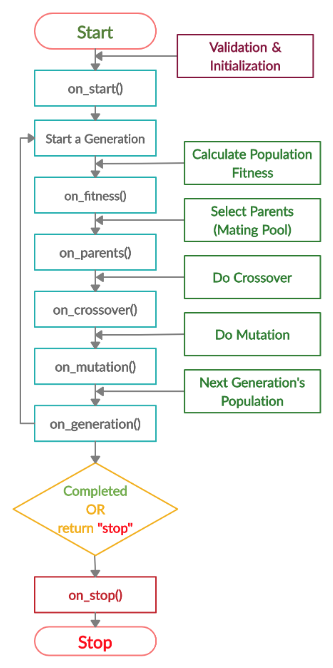

## Setup

In [1]:
import pandas as pd
import math
import numpy as np
import random
import pygad
from datetime import datetime
import matplotlib.pyplot as plt


## Definiciones varias

In [2]:
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "City(" + str(self.x) + "," + str(self.y) + ")"

class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness = 0.0
    
    def routeDistance(self):
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness


In [9]:

# determine whether to stop a generation after x iterations of no improvement
def stop_gen(g, x):
    if g.generations_completed > x:
        max_index = g.generations_completed - 1
        curr_fitness = g.best_solutions_fitness[max_index]
        x_back_fitness = g.best_solutions_fitness[max_index - x]
        if math.isclose(curr_fitness, x_back_fitness, abs_tol=0.00003):
            return True
    return False

def print_route(route, title): 
    x_coordinates = [c.x for c in route] + [route[0].x]
    y_coordinates = [c.y for c in route] + [route[0].y]
    plt.scatter(x_coordinates, y_coordinates)
    plt.plot(x_coordinates, y_coordinates)
    plt.xlabel("x distance")
    plt.ylabel("y distance")
    plt.title(title)

class RunManager:
    def __init__(self, initial_population, generations):
        self.initial_population = initial_population
        self.generations = generations
    
    def fitness_func(self, route_raw, _):
        """Computes the fitness of a given route."""
        route = [self.initial_population[int(i)-1] for i in route_raw]
        return Fitness(route).routeFitness()

    def on_generation(self, g):
        """Call back on each generation run."""
        print(f"[{g.generations_completed+1}/{self.generations}] Current best route score: {round(1 / g.best_solutions_fitness[-1], 4)}")
        x = 500
        if stop_gen(g, x):
            return "stop"
        

# cityList = []
# for i in range(0, 20):
#     cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))

# run_manager = RunManager(cityList, 200)
# run_manager.fitness_func(range(len(cityList)), _)

## Implicaciones de Distintas configuraciones del Algoritmo

- Soluciones por población:
    - Valores demasiado bajos resultand en un mínimos locales
    - Valores demasiado altosaumento del tiempo de cálculo

- Generaciones
    - Si es muy bajo no se alcanza una meseta en la funcion de fitness => Esto implica que el algoritmo aun no encontró una solución óptima.
    - Si es demasiado alto, el algotirmo sigue corriendo aun cuando ya no se encontraron más mejoras => tiempo de cálculo desperdiciado
        - PyGAD permite definir [criterios de parada](https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html?#stop-criteria) para detener las corridas si se alcanza un óptimo.

- Un menor número de padres que se aparean resulta en demasiado "elitismo":
    - Al seleccionarse un pequeño subconjunto de padres, se reduce la diversidad y solo se obtienen los rasgos positivos de una pequeña porción de la población. No juega con las fortalezas del algoritmo genético.
        
- La mutación adaptativa ayuda a arrancar el proceso y a reducir el espacio de soluciones más rápido:
    - Uno de los problemas con la mutación aleatoria es que se descartan soluciones buenas demasiado rápido y no lo suficiente las mala. La mutación adaptativa tiene como objetivo resolver esto al tener un porcentaje de mutación mayor para todas las soluciones peores que el promedio y un porcentaje de mutación más bajo para todas las soluciones mejores que el promedio.


In [81]:
def geneticAlgorithm(
    population,
    popSize=250,
    eliteSize=...,
    mutationRate=...,
    mating_percent=25,
    generations=200,
):

    # assign the fitness function
    # fitness_function = trip_dist
    run_manager = RunManager(population, generations)

    # how many generations to iterate through
    # set this high and let the stop_gen funciton determine whether to end
    #  make sure to set the number of iterations in stop_gen sufficently high for your dataset
    # num_generations = 5000
    num_generations = generations

    # size of the population
    sol_per_pop = popSize

    # solution space
    num_genes = len(population)

    # solution range
    gene_space = range(1, len(population) + 1)

    # mate with the top x% of the population
    num_parents_mating = math.ceil(sol_per_pop * mating_percent / 100)

    # keep the top x% of the population for the next generation
    # 1% works good for larger population (>1000), else 5% is good
    keep_percent = 5
    # keep_percent = .001
    keep_parents = math.ceil(sol_per_pop * keep_percent / 100)

    # choose how to select parents
    # parent_selection_type = "sss"
    parent_selection_type = "rank"

    # crossover the data from single point and two point was indistinguishable
    # but two point was more resource intensive
    crossover_type = "single_point"
    # crossover_type = "two_points"

    # how to implement mutation
    mutation_type = "adaptive"

    # will throw warning if percent * MAX_CITIES < 1 (i.e. in tsp1.csv)
    # [20, 5] has produced the best results
    mutation_percent_genes = [20, 5]

    # initialize the genetic algorithm parameters
    ga_instance = pygad.GA(
        num_generations=num_generations,
        num_parents_mating=num_parents_mating,
        # fitness_func=fitness_function,
        fitness_func=lambda route, _: run_manager.fitness_func(route, _),
        sol_per_pop=sol_per_pop,
        num_genes=num_genes,
        parent_selection_type=parent_selection_type,
        keep_parents=keep_parents,
        crossover_type=crossover_type,
        mutation_type=mutation_type,
        mutation_percent_genes=mutation_percent_genes,
        gene_space=gene_space,
        # on_generation=on_generation,
        on_generation=lambda g: run_manager.on_generation(g),
        allow_duplicate_genes=False,
        # parallel_processing=["thread", None],
    )

    # run an instance of the genetic algorithm
    ga_instance.run()
    return ga_instance


## Main

Runs the genetic algorithm and outputs the best solution found.

In [53]:
cityList = []
for i in range(0, 20):
    cityList.append(City(x=int(random.random() * 200), y=int(random.random() * 200)))


In [106]:
%%time
ga_instance = geneticAlgorithm(population=cityList, popSize=20, generations=300)

[2/300] Current best route score: 1524.0176
[3/300] Current best route score: 1524.0176
[4/300] Current best route score: 1486.8286
[5/300] Current best route score: 1465.3542
[6/300] Current best route score: 1465.3542
[7/300] Current best route score: 1465.3542
[8/300] Current best route score: 1340.3219
[9/300] Current best route score: 1340.3219
[10/300] Current best route score: 1307.2119
[11/300] Current best route score: 1307.2119
[12/300] Current best route score: 1245.1833
[13/300] Current best route score: 1245.1833
[14/300] Current best route score: 1245.1427
[15/300] Current best route score: 1241.1056
[16/300] Current best route score: 1241.1056
[17/300] Current best route score: 1241.1056
[18/300] Current best route score: 1241.1056
[19/300] Current best route score: 1241.1056
[20/300] Current best route score: 1230.4262
[21/300] Current best route score: 1211.7961
[22/300] Current best route score: 1211.7961
[23/300] Current best route score: 1211.7961
[24/300] Current b

[204/300] Current best route score: 1032.4436
[205/300] Current best route score: 1032.4436
[206/300] Current best route score: 1032.4436
[207/300] Current best route score: 1032.4436
[208/300] Current best route score: 1032.4436
[209/300] Current best route score: 1032.4436
[210/300] Current best route score: 1032.4436
[211/300] Current best route score: 1032.4436
[212/300] Current best route score: 1032.4436
[213/300] Current best route score: 1032.4436
[214/300] Current best route score: 1032.4436
[215/300] Current best route score: 1032.4436
[216/300] Current best route score: 1032.4436
[217/300] Current best route score: 1032.4436
[218/300] Current best route score: 1032.4436
[219/300] Current best route score: 1032.4436
[220/300] Current best route score: 1032.4436
[221/300] Current best route score: 1032.4436
[222/300] Current best route score: 1032.4436
[223/300] Current best route score: 1032.4436
[224/300] Current best route score: 1032.4436
[225/300] Current best route score

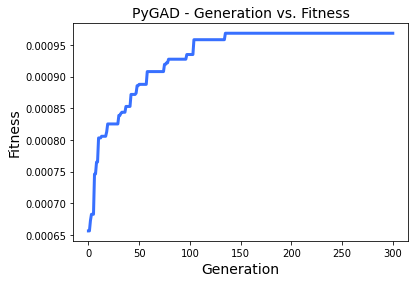

In [107]:
_ = ga_instance.plot_fitness()

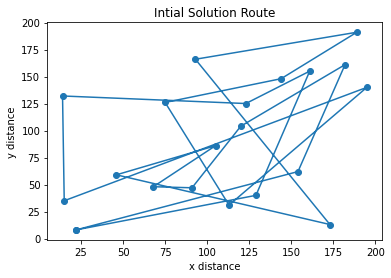

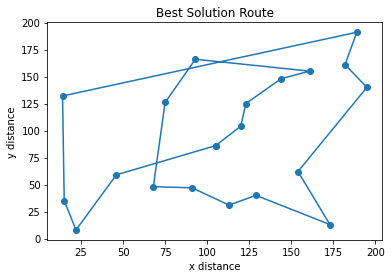

In [108]:
   
bestRoute = [
    cityList[i-1] for i in ga_instance.best_solution()[0].astype(int)
]
print_route(cityList, "Intial Solution Route")
plt.show()
print_route(bestRoute, "Best Solution Route")
plt.show()

# References

* https://github.com/mstpn/PyGAD_TSP/blob/main/PyGAD_TSP.ipynb

